In [51]:
#Usual importing to start
import xgboost as xgb
from astropy.io import fits
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from astropy.table import Table, hstack, vstack
from collections import Counter
import pandas as pd

In [ ]:
#Open the data
data1 = Table.read('big_table_1.fits',format = 'fits')
data2 = Table.read('big_table_2.fits',format = 'fits')
data3 = Table.read('big_table_3.fits',format = 'fits')
data4 = Table.read('big_table_4.fits',format = 'fits')
data5 = Table.read('big_table_5.fits',format = 'fits')
data6 = Table.read('big_table_6.fits',format = 'fits')
data7 = Table.read('big_table_7.fits',format = 'fits')
data8 = Table.read('big_table_8.fits',format = 'fits')

In [2]:
#Remove sources with proper motion
data1 = data1[~(abs(data1['pmra']/data1['pmra_error']) > 3)]
data2 = data2[~(abs(data2['pmra']/data2['pmra_error']) > 3)]
data3 = data3[~(abs(data3['pmra']/data3['pmra_error']) > 3)]
data4 = data4[~(abs(data4['pmra']/data4['pmra_error']) > 3)]
data5 = data5[~(abs(data5['pmra']/data5['pmra_error']) > 3)]
data6 = data6[~(abs(data6['pmra']/data6['pmra_error']) > 3)]
data7 = data7[~(abs(data7['pmra']/data7['pmra_error']) > 3)]
data8 = data8[~(abs(data8['pmra']/data8['pmra_error']) > 3)]
data1 = data1[~(abs(data1['pmdec']/data1['pmdec_error']) > 3)]
data2 = data2[~(abs(data2['pmdec']/data2['pmdec_error']) > 3)]
data3 = data3[~(abs(data3['pmdec']/data3['pmdec_error']) > 3)]
data4 = data4[~(abs(data4['pmdec']/data4['pmdec_error']) > 3)]
data5 = data5[~(abs(data5['pmdec']/data5['pmdec_error']) > 3)]
data6 = data6[~(abs(data6['pmdec']/data6['pmdec_error']) > 3)]
data7 = data7[~(abs(data7['pmdec']/data7['pmdec_error']) > 3)]
data8 = data8[~(abs(data8['pmdec']/data8['pmdec_error']) > 3)]

In [3]:
#Combine the data
data = vstack([data1,data2,data3,data4,data5,data6,data7,data8],metadata_conflicts = 'silent')

#Look at the distribution of object types
Counter(data['objtype'])

Counter({'': 1661905,
         'Star': 9771,
         'Galaxy': 133957,
         'other': 2134,
         'QSOlowZ': 15912,
         'QSOhighZ': 1880})

In [4]:
#Remove sources with parallax
data = data[~(data['parallax_over_error'] > 3)]

#Look at the distribution of object types
Counter(data['objtype'])

Counter({'': 1653159,
         'Galaxy': 133891,
         'other': 2132,
         'QSOlowZ': 15887,
         'Star': 1056,
         'QSOhighZ': 1877})

In [5]:
#Make a dataset from the QSOs alone to use for regression
z_data = data[(data['objtype'] == 'QSOlowZ') | (data['objtype'] == 'QSOhighZ')]

In [15]:
#Make the colors for the QSOs
z_g = np.vstack(z_data['phot_g_mean_mag']+z_data['gPSFMag'])/2
z_b_minus_g = np.vstack(z_data['phot_bp_mean_mag'])-z_g
z_g_minus_r = z_g-np.vstack(z_data['phot_rp_mean_mag']+z_data['rPSFMag'])/2
z_r_minus_i = np.vstack(z_data['phot_rp_mean_mag']+z_data['rPSFMag'])/2-np.vstack(z_data['iPSFMag'])
z_i_minus_y = np.vstack(z_data['iPSFMag'])-np.vstack(z_data['yPSFMag'])
z_y_minus_w1 = np.vstack(z_data['yPSFMag'])-np.vstack(z_data['w1mpro'])
z_w1_minus_w2 = np.vstack(z_data['w1mpro'])-np.vstack(z_data['w2mpro'])
z_w2_minus_w3 = np.vstack(z_data['w2mpro'])-np.vstack(z_data['w3mpro'])
z_w3_minus_w4 = np.vstack(z_data['w3mpro'])-np.vstack(z_data['w4mpro'])

#Put together the data
X = np.concatenate((z_g,z_b_minus_g,z_g_minus_r,z_r_minus_i,z_i_minus_y,z_y_minus_w1,z_w1_minus_w2,z_w2_minus_w3,z_w3_minus_w4),axis = 1)
y = z_data['z_spec']
X_train_z, X_test_z, Y_train_z, Y_test_z = train_test_split(X, y, test_size=0.2)
X_train_z = np.vstack(X_train_z)
Y_train_z = np.vstack(Y_train_z)
X_test_z = np.vstack(X_test_z)
Y_test_z = np.vstack(Y_test_z)

R^2: [0.91758952 0.92071315 0.87173182 0.84481313 0.8667109 ]


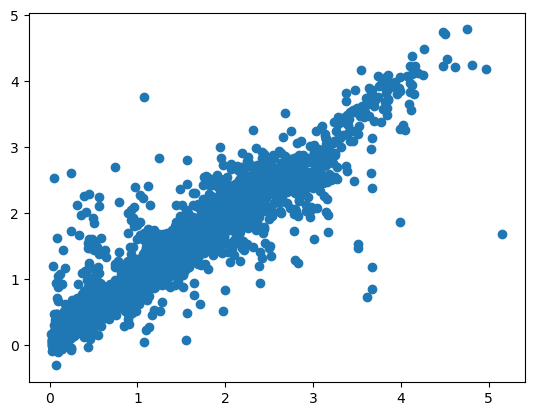

In [16]:
#Run the model
steps = 20  # The number of training iterations
model = xgb.XGBRegressor()
model.fit(X_train_z,Y_train_z)

#Plot predicted vs true
preds = model.predict(X_test_z)
plt.scatter(Y_test_z,preds)

#Cross validate to find R^2
scores = cross_val_score(model, X, y, scoring='r2', n_jobs=-1)
print('R^2:',scores)

In [17]:
#Make the colors for the whole sample
g = np.vstack(data['phot_g_mean_mag']+data['gPSFMag'])/2
b_minus_g = np.vstack(data['phot_bp_mean_mag'])-g
g_minus_r = g-np.vstack(data['phot_rp_mean_mag']+data['rPSFMag'])/2
r_minus_i = np.vstack(data['phot_rp_mean_mag']+data['rPSFMag'])/2-np.vstack(data['iPSFMag'])
i_minus_y = np.vstack(data['iPSFMag'])-np.vstack(data['yPSFMag'])
y_minus_w1 = np.vstack(data['yPSFMag'])-np.vstack(data['w1mpro'])
w1_minus_w2 = np.vstack(data['w1mpro'])-np.vstack(data['w2mpro'])
w2_minus_w3 = np.vstack(data['w2mpro'])-np.vstack(data['w3mpro'])
w3_minus_w4 = np.vstack(data['w3mpro'])-np.vstack(data['w4mpro'])

In [18]:
#Put the colors together to make a prediction
X_all = np.concatenate((g,b_minus_g,g_minus_r,r_minus_i,i_minus_y,y_minus_w1,w1_minus_w2,w2_minus_w3,w3_minus_w4),axis = 1)

#Assign an ostensible z for each source, assuming it is a QSO
z_if_qso = model.predict(X_all)

#Discard those sources with ostensible z above 2.5
data = data[z_if_qso > 2.5]
X_all = X_all[z_if_qso > 2.5]
z_if_qso = z_if_qso[z_if_qso > 2.5]

#Look at the distribution of object types
Counter(data['objtype'])

Counter({'': 195190,
         'Galaxy': 305,
         'QSOhighZ': 1455,
         'other': 11,
         'QSOlowZ': 216,
         'Star': 662})

In [22]:
#Add ostensible z to the input data
X_all = np.concatenate((X_all,np.vstack(z_if_qso)),axis = 1)

In [24]:
#Use only those sources that are labelled
X_labelled = X_all[data['objtype'] != '']
data_labelled = data[data['objtype'] != '']

In [36]:
#Create the target labels
Y_labelled = np.vstack((data_labelled['objtype'] == 'QSOhighZ')+(data_labelled['objtype'] == 'QSOlowZ')+2*(data_labelled['objtype'] == 'Galaxy')+3*(data_labelled['objtype'] == 'other'))
print(Y_labelled)

[[2]
 [2]
 [2]
 ...
 [0]
 [0]
 [1]]


In [37]:
#Separate test and training data
X_train, X_test, Y_train, Y_test = train_test_split(X_labelled, Y_labelled, test_size=0.2)
X_train = np.vstack(X_train)
Y_train = np.vstack(Y_train)
X_test = np.vstack(X_test)
Y_test = np.vstack(Y_test)

In [47]:
#Make testing and training matrices
#xg_train = xgb.DMatrix(X_train, label=Y_train)
#xg_test = xgb.DMatrix(X_test, label=Y_test)

#Choose model parameters
#param = {}
#param['objective'] = 'multi:softmax'
#param['eta'] = 0.1
#param['max_depth'] = 6
#param['nthread'] = 4
#param['num_class'] = 4

#Run the classifier
#watchlist = [(xg_train, 'train'), (xg_test, 'test')]
#num_round = 5
bst = xgb.XGBClassifier()
bst.fit(X_train,Y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [49]:
#Make predictions on the test set
predicted_classes = bst.predict(X_test)

In [52]:
#Show the confusion matrix
confusion_matrix(Y_test,predicted_classes)

array([[141,   1,   2,   0],
       [  2, 328,   1,   0],
       [  5,   4,  43,   0],
       [  0,   3,   0,   0]], dtype=int64)